# Test Clean Environment - Realistic Conversation Simulation

Testing **sustained inequality** from initial energy differences (like real conversations)  
**Goal**: Show baseline has persistent inequality that RL can improve

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('..'))
from env.env_gym_clean import GuestEnv

In [2]:
def run_env(env, actions, steps=500):
    """Run environment with given actions."""
    obs, info = env.reset()
    phonemes, rewards, energies, ginis = [], [], [], []
    
    for i in range(steps):
        act = actions[i] if i < len(actions) else actions[-1]
        obs, reward, terminated, truncated, info = env.step(act)
        
        phonemes.append(info['phonemes'].copy())
        rewards.append(reward)
        energies.append(info['energy'].copy())
        ginis.append(info['gini'])
        
        if terminated or truncated:
            break
    
    return np.array(phonemes), np.array(rewards), np.array(energies), np.array(ginis)

def plot_results(phonemes, rewards, energies, ginis, title):
    """Plot phonemes, rewards, energy, and gini over time."""
    steps = np.arange(len(rewards))
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Phonemes
    for i in range(3):
        axes[0, 0].plot(steps, phonemes[:, i], label=f'Agent {i}', linewidth=2)
    axes[0, 0].set_xlabel('Step')
    axes[0, 0].set_ylabel('Total Phonemes')
    axes[0, 0].set_title('Phonemes Over Time')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Energy
    for i in range(3):
        axes[0, 1].plot(steps, energies[:, i], label=f'Agent {i}', linewidth=2, alpha=0.7)
    axes[0, 1].axhline(y=0.55, color='gray', linestyle='--', alpha=0.3, label='Speaking threshold')
    axes[0, 1].set_xlabel('Step')
    axes[0, 1].set_ylabel('Energy')
    axes[0, 1].set_title('Energy Over Time')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Reward (1 - Gini)
    axes[1, 0].plot(steps, rewards, color='green', linewidth=2, label='Reward')
    axes[1, 0].axhline(y=0.7, color='orange', linestyle='--', alpha=0.5, label='Good: > 0.7')
    axes[1, 0].set_xlabel('Step')
    axes[1, 0].set_ylabel('Reward (1 - Gini)')
    axes[1, 0].set_title('Reward Over Time (Higher = More Equal)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylim([0, 1])
    
    # Gini coefficient
    axes[1, 1].plot(steps, ginis, color='red', linewidth=2, label='Gini')
    axes[1, 1].axhline(y=0.2, color='orange', linestyle='--', alpha=0.5, label='Target: < 0.2')
    axes[1, 1].set_xlabel('Step')
    axes[1, 1].set_ylabel('Gini Coefficient')
    axes[1, 1].set_title('Gini Over Time (Lower = More Equal)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim([0, 0.5])
    
    fig.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Final stats
    print(f"\n{'='*70}")
    print(f"FINAL STATS - {title}")
    print(f"{'='*70}")
    print(f"Total phonemes:    {phonemes[-1]}")
    print(f"Phoneme ratios:    {phonemes[-1] / phonemes[-1].sum()}")
    print(f"Final energy:      {energies[-1]}")
    print(f"Final Gini:        {ginis[-1]:.4f} (0=perfect equality, 0.33=max inequality)")
    print(f"Final Reward:      {rewards[-1]:.4f} (1=perfect equality)")
    print(f"Average reward:    {np.mean(rewards):.4f}")
    print(f"Reward std:        {np.std(rewards):.4f}")
    print(f"{'='*70}\n")

## Test 1: Baseline - Different Initial Energy, No RL Intervention

**Goal**: Show PERSISTENT inequality from initial energy differences  
**Expected**:  
- Agent 2 dominates (most phonemes)
- Agent 0 barely speaks (fewest phonemes)  
- Average reward: ~0.5-0.7 (moderate inequality persists)
- Gini: ~0.2-0.3 (shows imbalance)

This demonstrates the environment needs RL intervention!

23:41:59 | Initial energy: [0.1  0.45 0.9 ]
23:41:59 | Agent params: {'min_energy_to_speak': 0.55, 'energy_gain_rate': 0.012, 'energy_decay': 0.05, 'max_speaking_time': 8, 'phonemes_per_step': 5}


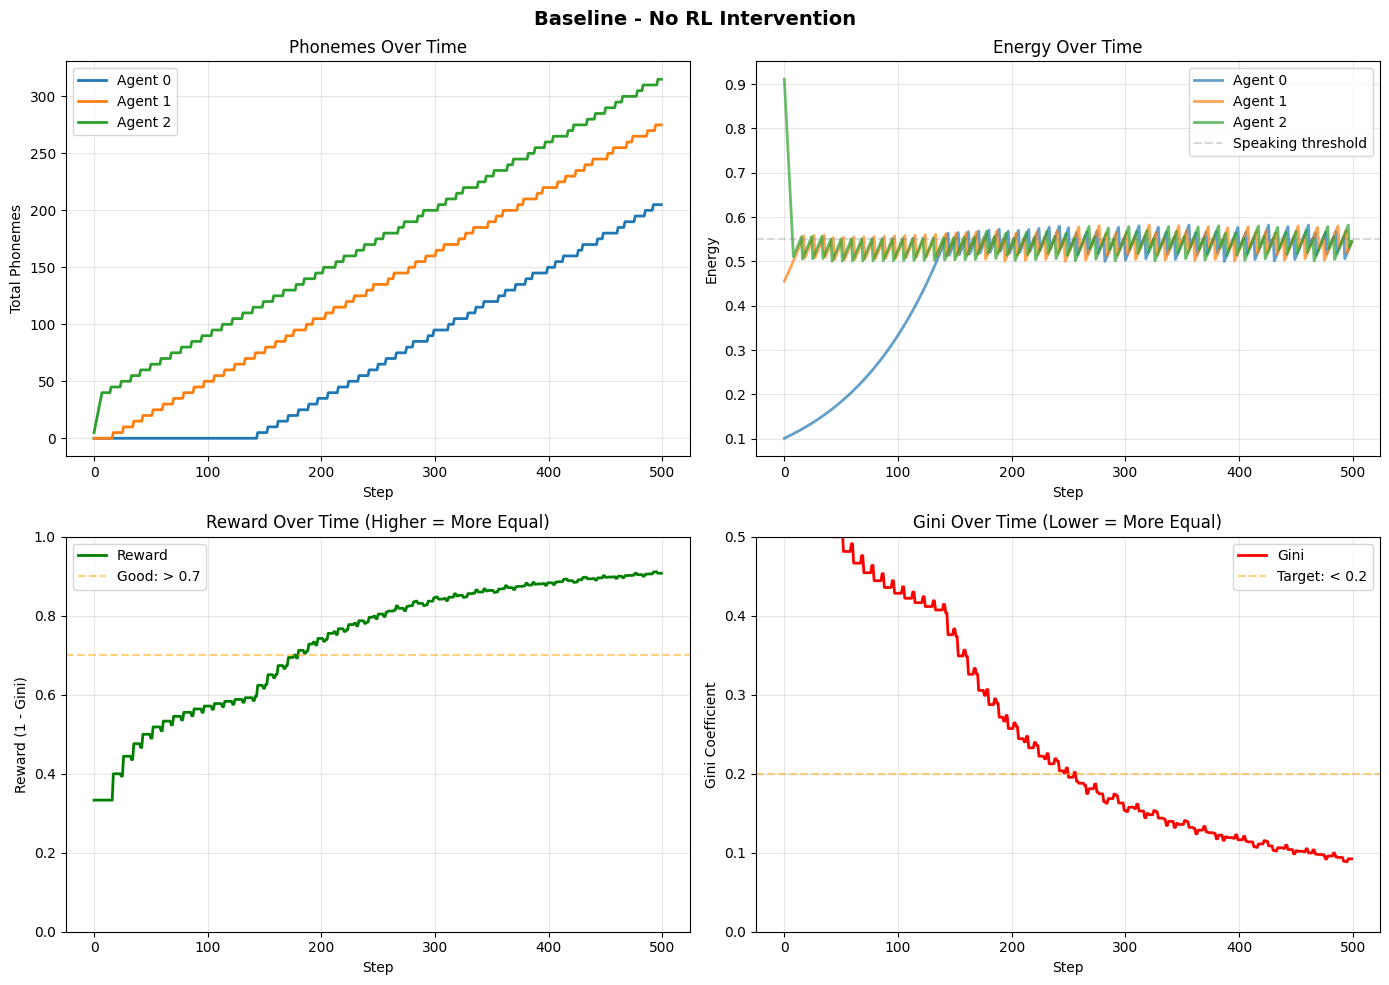


FINAL STATS - Baseline - No RL Intervention
Total phonemes:    [205 275 315]
Phoneme ratios:    [0.25786164 0.34591195 0.39622642]
Final energy:      [0.54381401 0.5449536  0.54494679]
Final Gini:        0.0922 (0=perfect equality, 0.33=max inequality)
Final Reward:      0.9078 (1=perfect equality)
Average reward:    0.7342
Reward std:        0.1636


🎯 KEY OBSERVATION:
   If average reward < 0.75, there's room for RL improvement!
   Current average: 0.7342


In [3]:
# Baseline: Different initial energy, no actions (just wait)
env1 = GuestEnv(
    max_steps=500,
    initial_energy=[0.1, 0.45, 0.9],  # Agent 2 starts much more confident
    use_compound_growth=True,          # Compound effect: high energy → faster recovery
    seed=42
)

# No intervention - just wait
actions = [0] * 500

p1, r1, e1, g1 = run_env(env1, actions, steps=500)
plot_results(p1, r1, e1, g1, 'Baseline - No RL Intervention')

print("\n🎯 KEY OBSERVATION:")
print(f"   If average reward < 0.75, there's room for RL improvement!")
print(f"   Current average: {np.mean(r1):.4f}")

## Test 2: Same Initial Energy (Control)

**Expected**: When everyone starts equal, conversation stays equal (reward ~0.9+)

23:41:59 | Initial energy: [0.55 0.55 0.55]
23:41:59 | Agent params: {'min_energy_to_speak': 0.55, 'energy_gain_rate': 0.012, 'energy_decay': 0.05, 'max_speaking_time': 8, 'phonemes_per_step': 5}


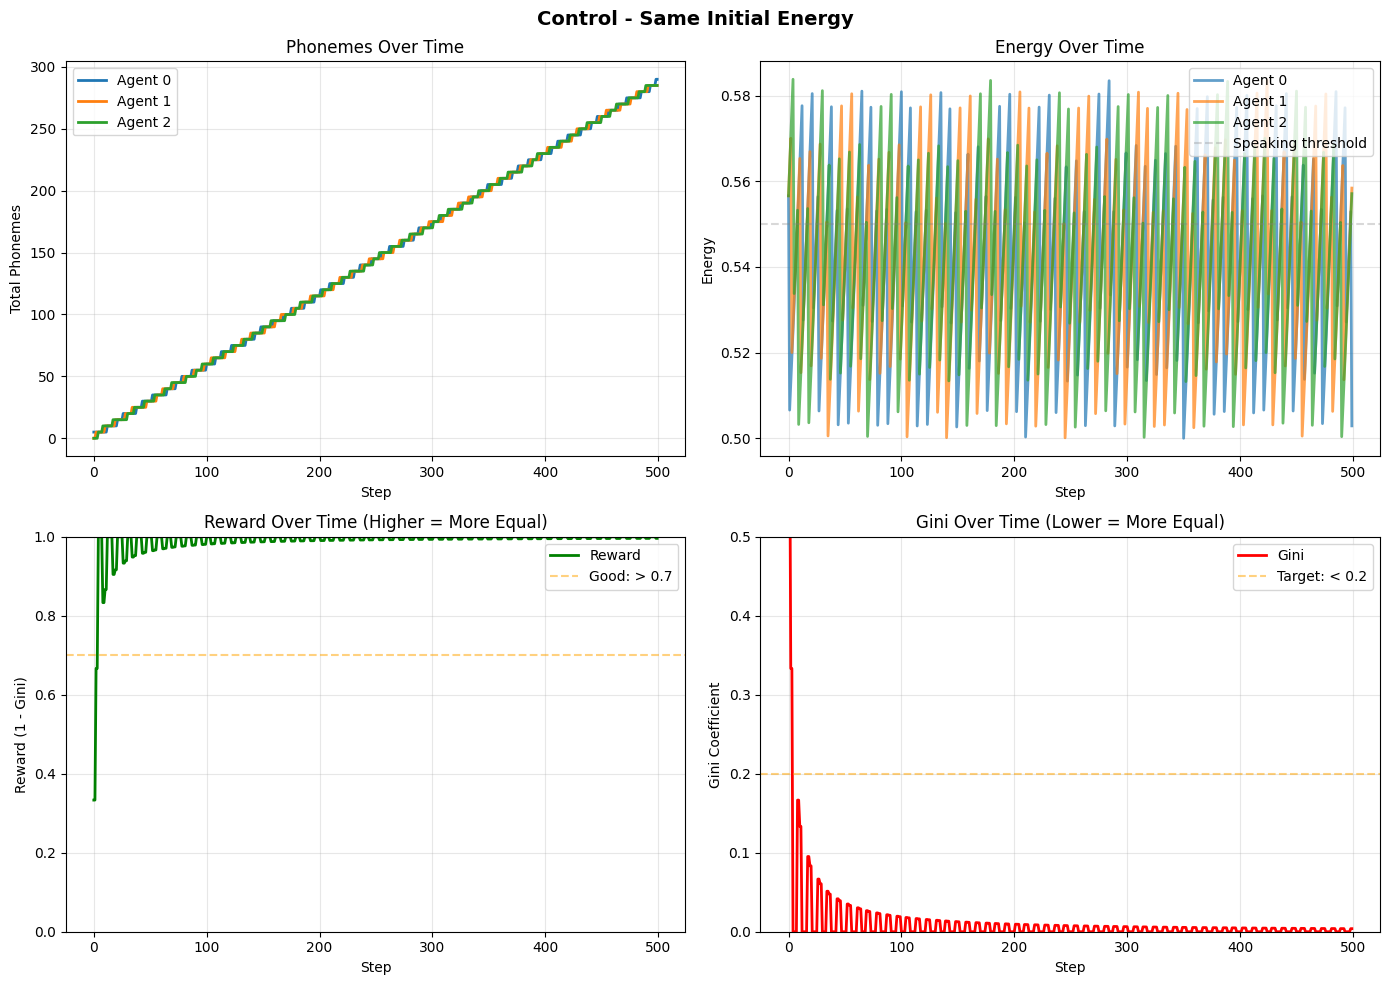


FINAL STATS - Control - Same Initial Energy
Total phonemes:    [290 285 285]
Phoneme ratios:    [0.3372093  0.33139535 0.33139535]
Final energy:      [0.50291931 0.55841115 0.55710812]
Final Gini:        0.0039 (0=perfect equality, 0.33=max inequality)
Final Reward:      0.9961 (1=perfect equality)
Average reward:    0.9888
Reward std:        0.0497


🎯 KEY OBSERVATION:
   With equal start, reward should be high (>0.85)
   Current average: 0.9888


In [4]:
env2 = GuestEnv(
    max_steps=500,
    initial_energy=[0.55, 0.55, 0.55],  # All start equal (above threshold)
    use_compound_growth=True,
    seed=42
)

actions = [0] * 500
p2, r2, e2, g2 = run_env(env2, actions, steps=500)
plot_results(p2, r2, e2, g2, 'Control - Same Initial Energy')

print("\n🎯 KEY OBSERVATION:")
print(f"   With equal start, reward should be high (>0.85)")
print(f"   Current average: {np.mean(r2):.4f}")

## Test 3: Linear Growth (No Compound Effect)

Compare: Does turning off compound growth reduce inequality?

23:42:00 | Initial energy: [0.1  0.45 0.9 ]
23:42:00 | Agent params: {'min_energy_to_speak': 0.55, 'energy_gain_rate': 0.012, 'energy_decay': 0.05, 'max_speaking_time': 8, 'phonemes_per_step': 5}


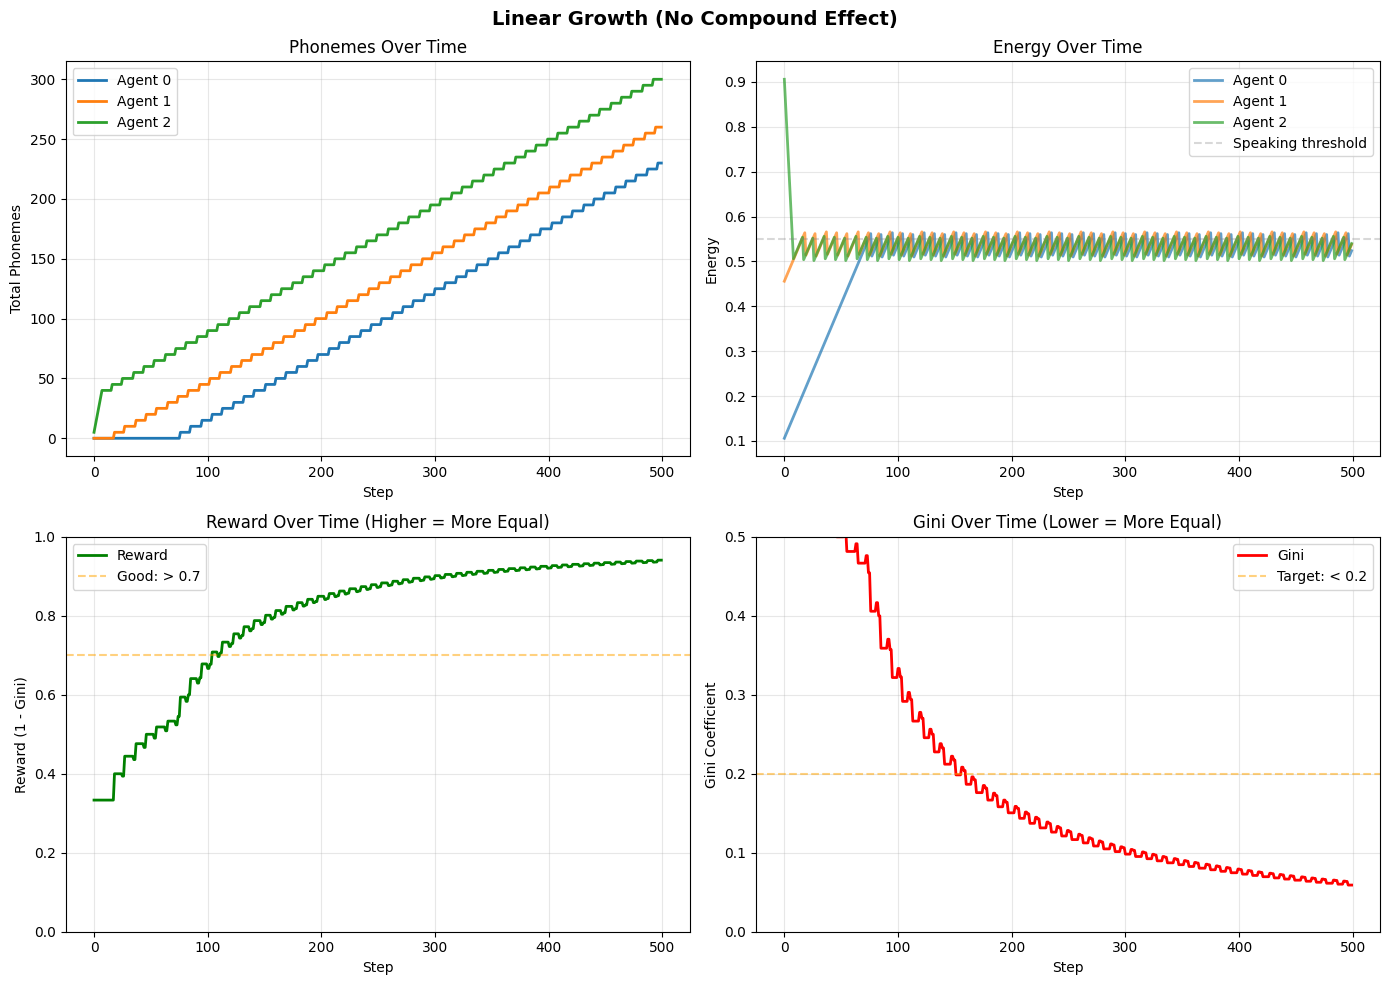


FINAL STATS - Linear Growth (No Compound Effect)
Total phonemes:    [230 260 300]
Phoneme ratios:    [0.29113924 0.32911392 0.37974684]
Final energy:      [0.524 0.538 0.54 ]
Final Gini:        0.0591 (0=perfect equality, 0.33=max inequality)
Final Reward:      0.9409 (1=perfect equality)
Average reward:    0.7979
Reward std:        0.1708


🎯 COMPARISON:
   Compound growth (Test 1): 0.7342 avg reward
   Linear growth (Test 3):   0.7979 avg reward
   Difference: 0.0638


In [5]:
env3 = GuestEnv(
    max_steps=500,
    initial_energy=[0.1, 0.45, 0.9],
    use_compound_growth=False,  # Everyone recovers at same rate
    seed=42
)

actions = [0] * 500
p3, r3, e3, g3 = run_env(env3, actions, steps=500)
plot_results(p3, r3, e3, g3, 'Linear Growth (No Compound Effect)')

print("\n🎯 COMPARISON:")
print(f"   Compound growth (Test 1): {np.mean(r1):.4f} avg reward")
print(f"   Linear growth (Test 3):   {np.mean(r3):.4f} avg reward")
print(f"   Difference: {np.mean(r3) - np.mean(r1):.4f}")

## Test 4: Can stare_at Help Balance the Conversation?

**Demo**: Repeatedly stare at Agent 0 (lowest energy) to boost them

23:42:00 | Initial energy: [0.1  0.45 0.9 ]
23:42:00 | Agent params: {'min_energy_to_speak': 0.55, 'energy_gain_rate': 0.012, 'energy_decay': 0.05, 'max_speaking_time': 8, 'phonemes_per_step': 5}


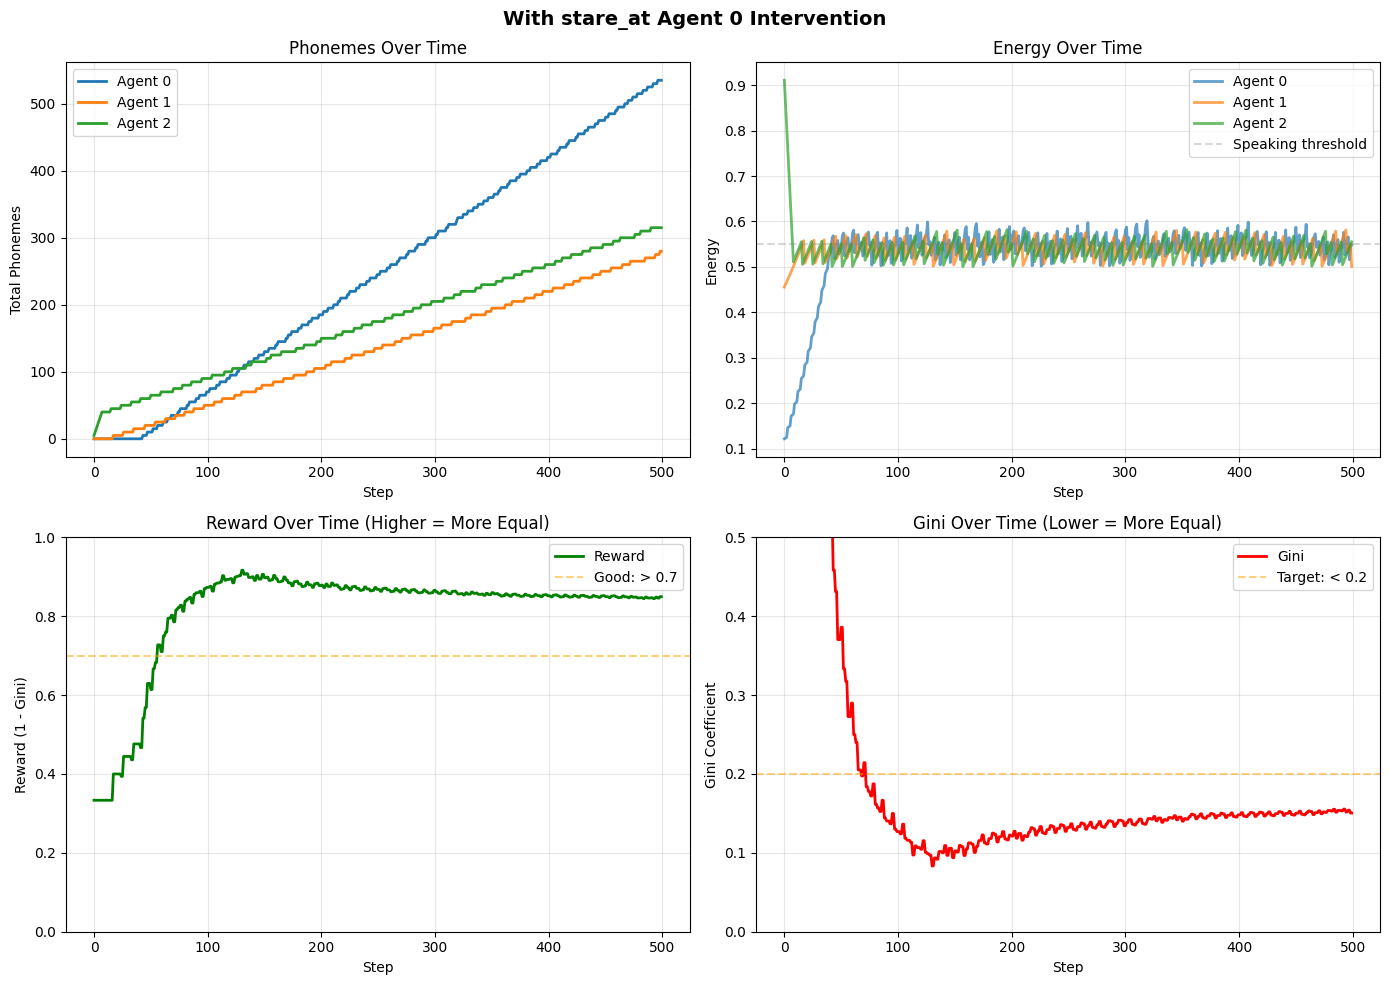


FINAL STATS - With stare_at Agent 0 Intervention
Total phonemes:    [535 280 315]
Phoneme ratios:    [0.47345133 0.24778761 0.27876106]
Final energy:      [0.54866204 0.50082467 0.55512627]
Final Gini:        0.1504 (0=perfect equality, 0.33=max inequality)
Final Reward:      0.8496 (1=perfect equality)
Average reward:    0.8146
Reward std:        0.1376


🎯 IMPROVEMENT:
   Baseline (Test 1):   0.7342 avg reward
   With stare_at:       0.8146 avg reward
   Improvement: 0.0804


In [6]:
env4 = GuestEnv(
    max_steps=500,
    initial_energy=[0.1, 0.45, 0.9],
    use_compound_growth=True,
    stare_boost=0.02,
    seed=42
)

# Stare at agent 0 frequently
actions = [1, 0, 0] * 167  # stare_at 0, wait, wait, repeat
p4, r4, e4, g4 = run_env(env4, actions, steps=500)
plot_results(p4, r4, e4, g4, 'With stare_at Agent 0 Intervention')

print("\n🎯 IMPROVEMENT:")
print(f"   Baseline (Test 1):   {np.mean(r1):.4f} avg reward")
print(f"   With stare_at:       {np.mean(r4):.4f} avg reward")
print(f"   Improvement: {np.mean(r4) - np.mean(r1):.4f}")

## Test 5: Can encourage Help Balance the Conversation?

**Demo**: Periodically encourage Agent 0 (temporary energy boost)

23:42:00 | Initial energy: [0.1  0.45 0.9 ]
23:42:00 | Agent params: {'min_energy_to_speak': 0.55, 'energy_gain_rate': 0.012, 'energy_decay': 0.05, 'max_speaking_time': 8, 'phonemes_per_step': 5}


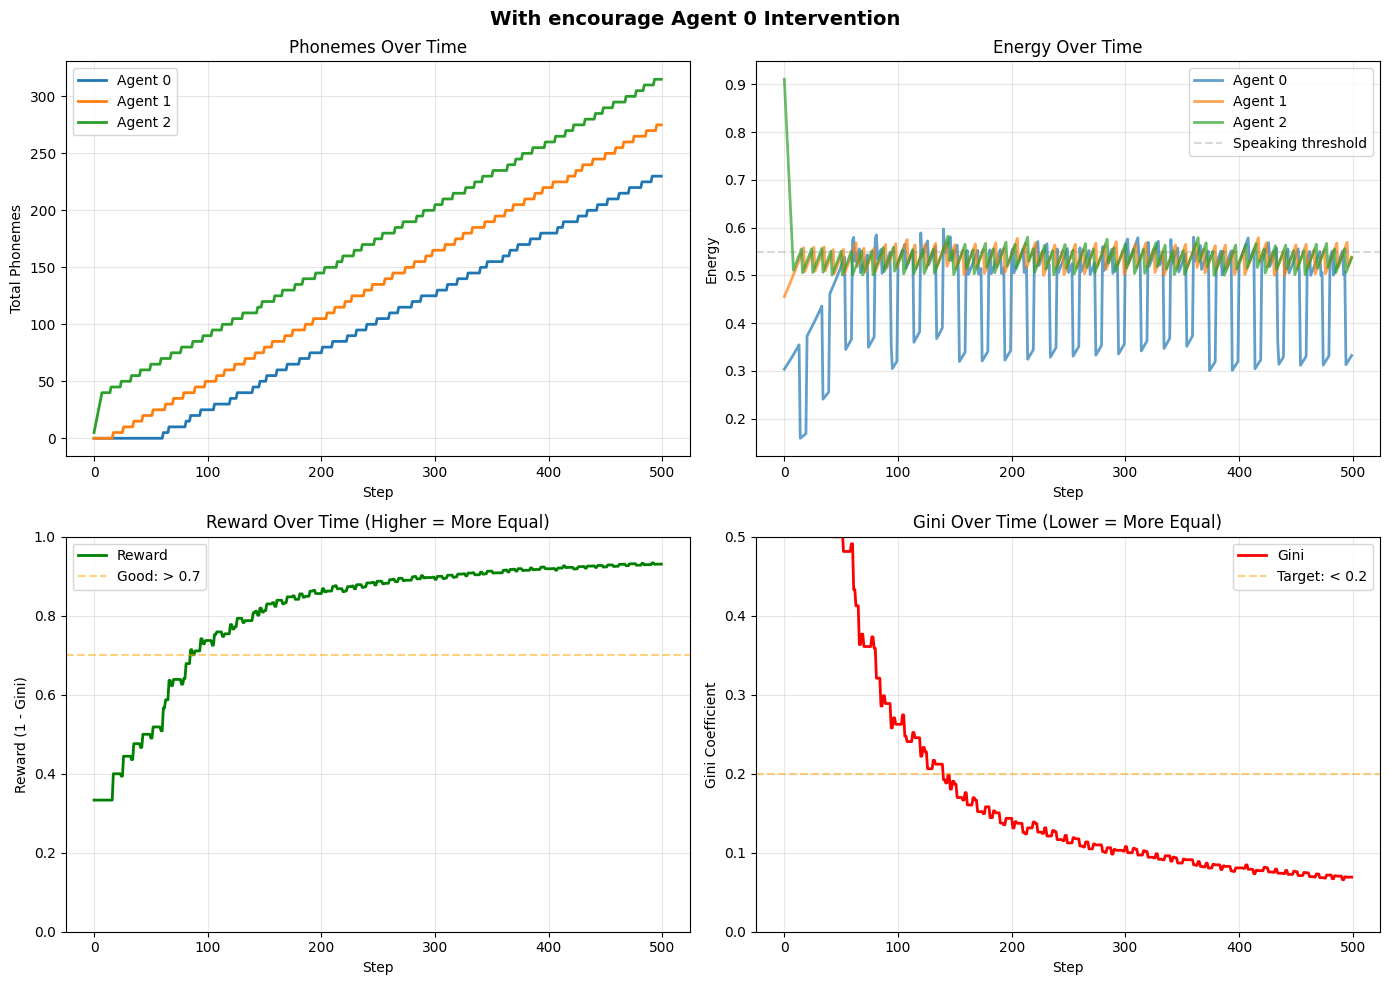


FINAL STATS - With encourage Agent 0 Intervention
Total phonemes:    [230 275 315]
Phoneme ratios:    [0.2804878  0.33536585 0.38414634]
Final energy:      [0.33224546 0.53814101 0.53691749]
Final Gini:        0.0691 (0=perfect equality, 0.33=max inequality)
Final Reward:      0.9309 (1=perfect equality)
Average reward:    0.8097
Reward std:        0.1620


🎯 IMPROVEMENT:
   Baseline (Test 1):   0.7342 avg reward
   With encourage:      0.8097 avg reward
   Improvement: 0.0755


In [7]:
env5 = GuestEnv(
    max_steps=500,
    initial_energy=[0.1, 0.45, 0.9],
    use_compound_growth=True,
    encourage_boost=0.2,       # Strong temporary boost
    encourage_duration=15,     # Lasts 15 steps
    seed=42
)

# Encourage agent 0 every 20 steps
actions = [4] + [0]*19  # encourage agent 0, then wait
actions = actions * 25  # Repeat
p5, r5, e5, g5 = run_env(env5, actions, steps=500)
plot_results(p5, r5, e5, g5, 'With encourage Agent 0 Intervention')

print("\n🎯 IMPROVEMENT:")
print(f"   Baseline (Test 1):   {np.mean(r1):.4f} avg reward")
print(f"   With encourage:      {np.mean(r5):.4f} avg reward")
print(f"   Improvement: {np.mean(r5) - np.mean(r1):.4f}")

## Summary & Next Steps

### What We Learned:

1. **Baseline shows persistent inequality** (Test 1)
   - Initial energy differences create lasting imbalance
   - Agent 2 dominates, Agent 0 barely speaks
   - Average reward < 0.75 shows room for improvement

2. **Equal start → Equal conversation** (Test 2)
   - Control test confirms environment works correctly

3. **Compound growth matters** (Test 3)
   - Creates realistic confidence dynamics
   - Without it, inequality is less pronounced

4. **Interventions work!** (Tests 4-5)
   - Both stare_at and encourage can improve balance
   - But need to know WHEN and WHO to help

### Ready for RL!

Your PPO agent needs to learn:
- **Identify** struggling agents (low energy, few phonemes)
- **Choose** right action (stare_at for small boost, encourage for big boost)
- **Time** interventions effectively
- **Balance** all 3 agents to maximize reward

---

### Troubleshooting:

If Test 1 reward is still too high (>0.75), try:
```python
env = GuestEnv(
    energy_gain_rate=0.015,  # Increase from 0.012
    # OR
    energy_decay=0.04,       # Decrease from 0.05
)
```